In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl
Training results should now be reproducible.


# Train model

Running trial 1/3 for mft.enabled=False
Running trial 2/3 for mft.enabled=False


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7329, Train Acc: 54.41%, Val Acc: 88.69%
Epoch [2/10], Loss: 0.9532, Train Acc: 85.37%, Val Acc: 90.05%
Epoch [3/10], Loss: 0.4328, Train Acc: 90.26%, Val Acc: 92.64%
Epoch [4/10], Loss: 0.2562, Train Acc: 93.65%, Val Acc: 94.01%
Epoch [5/10], Loss: 0.1624, Train Acc: 96.67%, Val Acc: 93.46%
Epoch [6/10], Loss: 0.1189, Train Acc: 97.59%, Val Acc: 95.10%
Epoch [7/10], Loss: 0.0811, Train Acc: 98.81%, Val Acc: 95.64%
Epoch [8/10], Loss: 0.0645, Train Acc: 99.12%, Val Acc: 92.64%
Epoch [9/10], Loss: 0.0562, Train Acc: 99.39%, Val Acc: 95.10%
Epoch [10/10], Loss: 0.0712, Train Acc: 99.25%, Val Acc: 95.23%
Total elapsed: 126.60s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/57646901eef92818d257bf2dfb097b74.pth
Running trial 3/3 for mft.enabled=False


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7069, Train Acc: 57.13%, Val Acc: 88.83%
Epoch [2/10], Loss: 0.9628, Train Acc: 84.79%, Val Acc: 90.74%
Epoch [3/10], Loss: 0.4198, Train Acc: 90.73%, Val Acc: 92.92%
Epoch [4/10], Loss: 0.2633, Train Acc: 93.79%, Val Acc: 94.41%
Epoch [5/10], Loss: 0.1677, Train Acc: 96.57%, Val Acc: 94.28%
Epoch [6/10], Loss: 0.1181, Train Acc: 97.93%, Val Acc: 95.23%
Epoch [7/10], Loss: 0.0938, Train Acc: 98.51%, Val Acc: 95.64%
Epoch [8/10], Loss: 0.0637, Train Acc: 98.91%, Val Acc: 95.37%
Epoch [9/10], Loss: 0.0614, Train Acc: 99.08%, Val Acc: 94.96%
Epoch [10/10], Loss: 0.0724, Train Acc: 99.42%, Val Acc: 95.10%
Total elapsed: 126.27s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/60e60bd43c20fa07a5060a2c35b1d20a.pth
Running trial 1/3 for mft.enabled=True,mft.k=100
Running trial 2/3 for mft.enabled=True,mft.k=100


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.9061, Train Acc: 50.68%, Val Acc: 85.97%
Epoch [2/10], Loss: 1.6718, Train Acc: 81.09%, Val Acc: 90.87%
Epoch [3/10], Loss: 1.0475, Train Acc: 82.89%, Val Acc: 90.19%
Epoch [4/10], Loss: 0.7200, Train Acc: 85.81%, Val Acc: 92.37%
Epoch [5/10], Loss: 0.5421, Train Acc: 88.46%, Val Acc: 92.37%
Epoch [6/10], Loss: 0.4665, Train Acc: 89.27%, Val Acc: 93.05%
Epoch [7/10], Loss: 0.3778, Train Acc: 91.17%, Val Acc: 93.73%
Epoch [8/10], Loss: 0.3442, Train Acc: 91.34%, Val Acc: 93.32%
Epoch [9/10], Loss: 0.3085, Train Acc: 92.46%, Val Acc: 93.87%
Epoch [10/10], Loss: 0.3021, Train Acc: 92.16%, Val Acc: 94.01%
Total elapsed: 126.89s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/7e2e385edf785bb516341f7761fb60c5.pth
Running trial 3/3 for mft.enabled=True,mft.k=100


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.8798, Train Acc: 53.09%, Val Acc: 87.47%
Epoch [2/10], Loss: 1.6817, Train Acc: 79.26%, Val Acc: 89.92%
Epoch [3/10], Loss: 1.0363, Train Acc: 82.72%, Val Acc: 90.60%
Epoch [4/10], Loss: 0.7285, Train Acc: 85.54%, Val Acc: 91.55%
Epoch [5/10], Loss: 0.5561, Train Acc: 87.54%, Val Acc: 92.37%
Epoch [6/10], Loss: 0.4545, Train Acc: 89.00%, Val Acc: 93.05%
Epoch [7/10], Loss: 0.3981, Train Acc: 90.87%, Val Acc: 92.92%
Epoch [8/10], Loss: 0.3484, Train Acc: 91.04%, Val Acc: 93.32%
Epoch [9/10], Loss: 0.3232, Train Acc: 91.85%, Val Acc: 93.87%
Epoch [10/10], Loss: 0.2979, Train Acc: 93.01%, Val Acc: 93.60%
Total elapsed: 129.56s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/39528a0f0b94e512f474a160dcfa7e58.pth
Elapsed training time: 126.6284841526661 for mft.enabled=False
Elapsed training time: 127.95255203700071 for mft.enabled=True,mft.k=100
Final mean val acc: 95.19 % for mft.enabled=False
Final mean val acc: 93.91 % for mft.enabled=

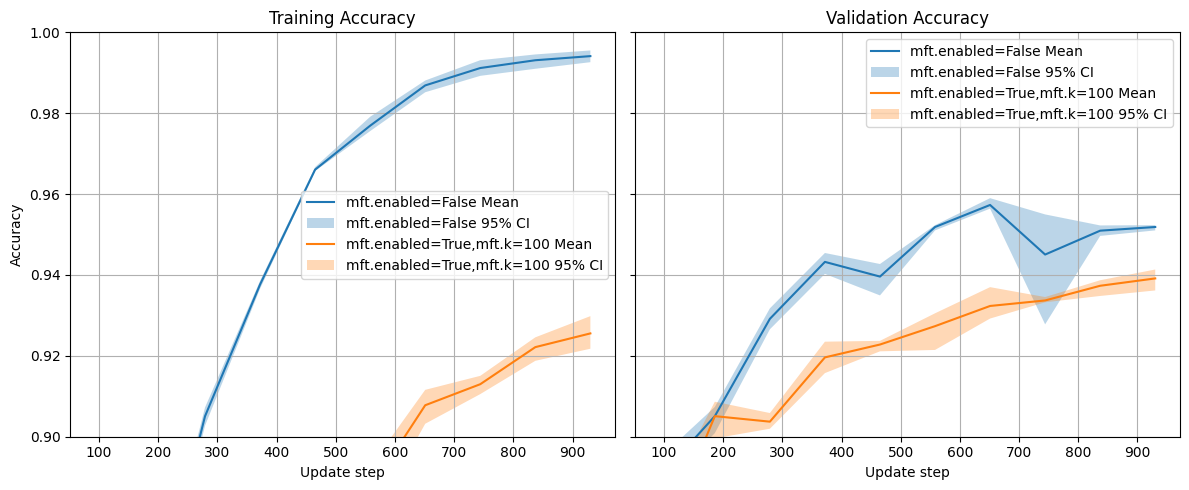

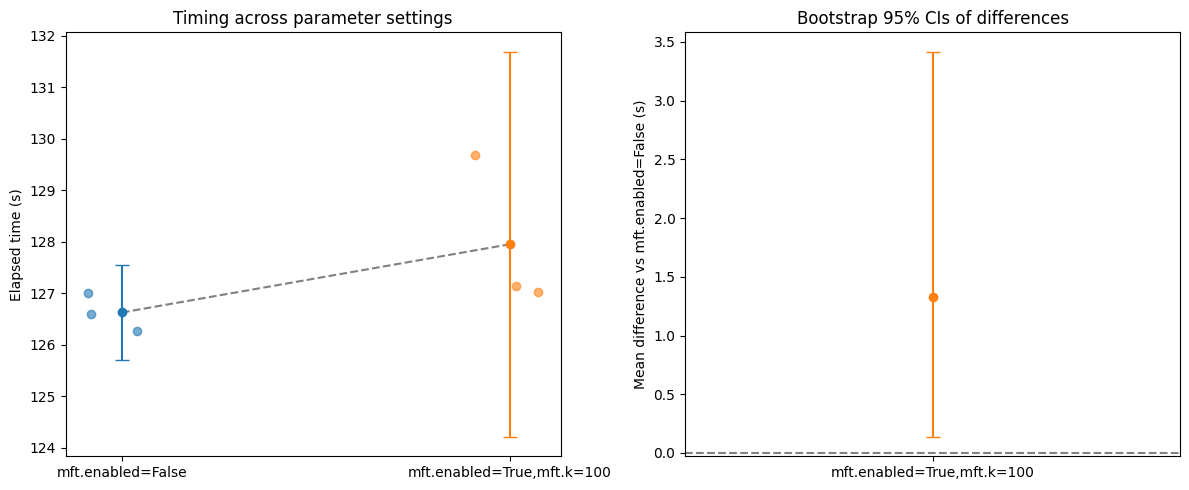

In [11]:
%reload_ext autoreload
%autoreload 2

from typing import Literal
import augmentation
from augmentation import AugmentationParams
from training import TrainParams, NagParams
from freezing import MaskedFineTuningParams
from evaluation import evaluate_test_accuracy_and_misclassified, evaluate_elapsed_time
from datasets import DatasetParams
from evaluation import override_param_sets, evaluate_runs_ci, evaluate_runs_print
from run import run_multiple

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    #class_fractions=(0.2,)*37,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.0055905797197103695,
        weight_decay=9.123321505007701e-06,
        momentum=0.791610254744395,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    augmentation=AugmentationParams(
        enabled=True,
        transform=augmentation.to_transform(architecture, ["resize", "flip"])
    ),
    mft=MaskedFineTuningParams(
        enabled=False,
        k=100,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

overrides = [
    dict(mft=dict(enabled=False)),
    #dict(mft=dict(enabled=True, k=5)),
    #dict(mft=dict(enabled=True, k=10)),
    dict(mft=dict(enabled=True, k=100)),
    #dict(mft=dict(enabled=True, k=4000)),
    #dict(mft=dict(enabled=True, k=4607)),
    #dict(mft=dict(enabled=True, k=4608)),
    #dict(mft=dict(enabled=True, k=1000000)),
]
param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, param_sets, determinism, invalidate=False, trials=3)
evaluate_runs_print(results)
evaluate_runs_ci(results)
evaluate_elapsed_time(results, "mft.enabled=False")


# Test model

In [ ]:

from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

eval_params = baseline_params.copy()

eval_params.n_epochs = 20
eval_params.augmentation.enabled = True
eval_params.augmentation.transform = augmentation.auto_transform(eval_params.architecture)
eval_params.optimizer.learning_rate = 0.005
eval_params.optimizer.weight_decay = 2.0e-05

trainer = try_loading_trainer(dataset_params, eval_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# Misclassified images

In [ ]:
from evaluation import show_misclassified

final_test_acc, misclassified_samples = evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")
show_misclassified(misclassified_samples)